In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from heatmap import heatmap, corrplot
from scanpy import read_h5ad
import sctop as top

In [2]:
sns.set(context='talk', font_scale=1.0, color_codes=True, style='ticks',
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':300, 'text.usetex':False, 'pdf.fonttype':42}, palette='tab10')

# CellBench

In [3]:
# These csv files were extracted from:
# https://github.com/LuyiTian/sc_mixology/blob/master/data/sincell_with_class_5cl.RData

cellbench_counts = pd.read_csv(
    '/projectnb/biophys/mariay/scTOP_manuscript_data/CellBench/from_R_file/single_cell_5cl_counts.csv')
cellbench_counts.set_index('Unnamed: 0', inplace=True)
cellbench_single_status = pd.read_csv(
    '/projectnb/biophys/mariay/scTOP_manuscript_data/CellBench/from_R_file/double_vs_single.csv')
cellbench_types = pd.read_csv(
    '/projectnb/biophys/mariay/scTOP_manuscript_data/CellBench/from_R_file/cell_line.csv')

In [4]:
# Drop cells that are marked as doubles
single_condition = cellbench_single_status['x'] == 'SNG'
cellbench_types = cellbench_types[single_condition]
cellbench_counts = cellbench_counts.loc[:, (cellbench_single_status['x'] == 'SNG').values]

In [5]:
cellbench_types_set, cellbench_types_count = np.unique(cellbench_types['x'], return_counts=True)

In [6]:
type_expressions_list = []
training_indices = []

for cb_type in tqdm(cellbench_types_set):
    current_type_indices = np.where(cellbench_types==cb_type)[0]
    
    # Choose n_training cells to use for the basis
    n_training = 200
    random_indices = np.random.choice(current_type_indices, n_training, replace=False)
    training_indices += [random_indices]
    
    current_raw = cellbench_counts.iloc[:, random_indices]
    current_processed = top.process(current_raw, average=True)
    type_expressions_list.append(current_processed)

training_indices = np.concatenate(training_indices)
cb_basis = pd.concat(type_expressions_list, axis=1)
cb_basis.columns = cellbench_types_set

100%|██████████| 5/5 [00:00<00:00, 37.79it/s]


In [7]:
test_indices = range(cellbench_counts.shape[1])
test_indices = np.delete(test_indices, training_indices)

In [8]:
test_processed = top.process(cellbench_counts.iloc[:, test_indices])
test_projections = top.score(cb_basis, test_processed)

In [9]:
accuracies = {'top1': 0,
              'top3': 0,
              'unspecified': 0,
              'total_cells': len(test_indices)
             }
predicted_labels = []
predicted_labels_specified = []
true_labels = []

for cell_number, cell_info in enumerate(test_projections.iteritems()):
    cell_name, cell_projections = cell_info
    types_sorted_by_projections = cell_projections.sort_values(ascending=False).index
    true_type = cellbench_types.iloc[test_indices]['x'].iloc[cell_number]
    
    true_labels += [true_type]
    top_type = types_sorted_by_projections[0]
    predicted_labels += [top_type]
    if cell_projections.max() < 0.1:
        predicted_labels_specified += ['Unspecified']
    else:
        predicted_labels_specified += [top_type]
    
    # cells with maximum projection under this value are considered "unspecified"
    specification_value = 0.1
    
    if types_sorted_by_projections[0] == true_type:
        accuracies['top1'] += 1
    if true_type in types_sorted_by_projections[:3]:
        accuracies['top3'] += 1
    if cell_projections.max() < 0.1:
        accuracies['unspecified'] += 1

In [10]:
predicted_labels == predicted_labels_specified

True

In [12]:
predicted_labels == true_labels

True

In [17]:
print(accuracies)

{'top1': 2822, 'top3': 2822, 'unspecified': 0, 'total_cells': 2822}


In [9]:
heatmap_list = []

for cb_type in cellbench_types_set:
    current_type_indices = np.where(cellbench_types.iloc[test_indices]==cb_type)[0]
    current_projections = top.score(cb_basis, test_processed.iloc[:, current_type_indices])
    heatmap_list.append(current_projections.mean(axis=1))
    
heatmap_projections = pd.concat(heatmap_list, axis=1)
heatmap_projections.columns = cellbench_types_set

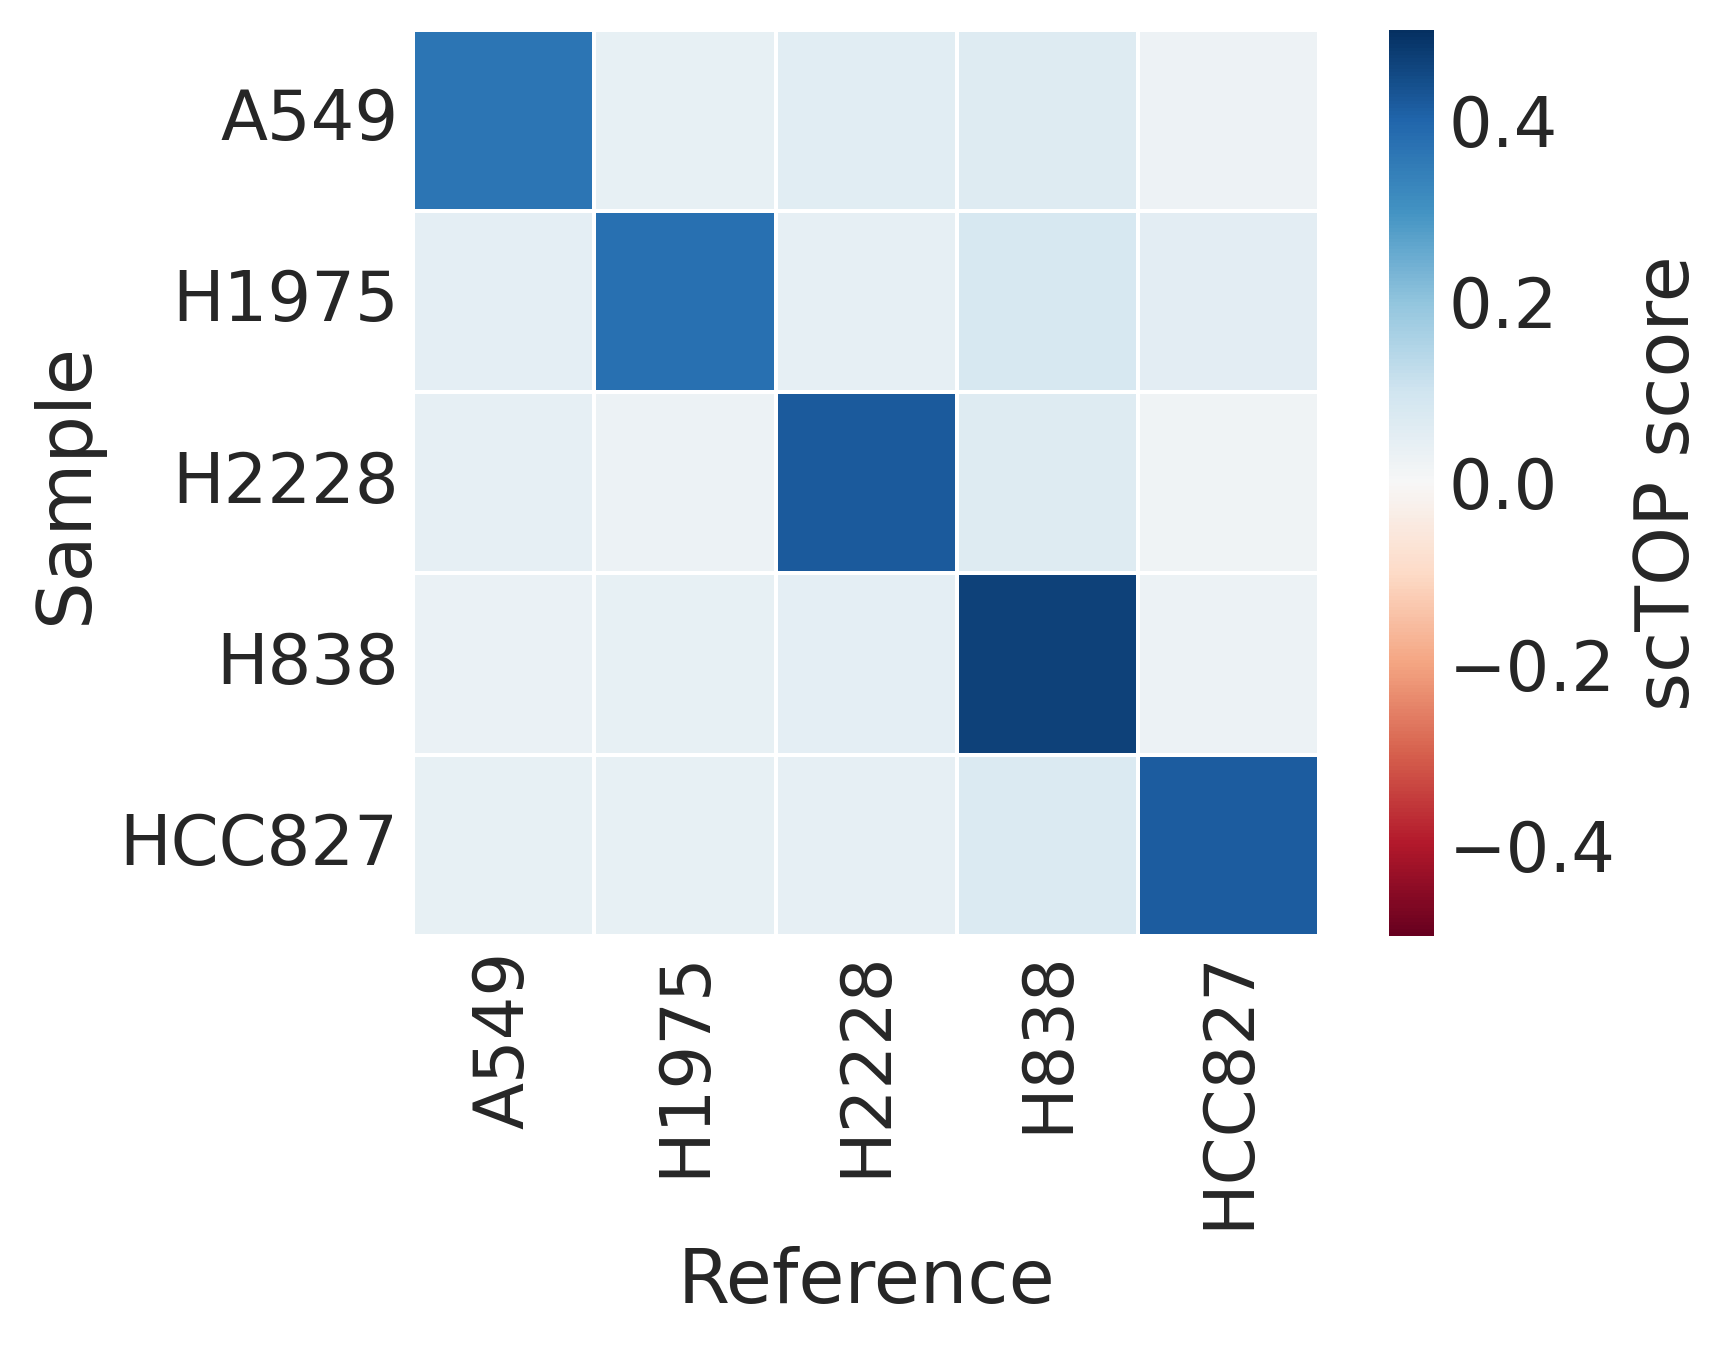

In [10]:
sns.heatmap(heatmap_projections.T, cmap="RdBu", 
            vmin=-0.5, vmax=0.5, 
            linewidths=.5, square=True, cbar_kws={'label':'scTOP score'})
plt.xlabel('Reference')
plt.ylabel('Sample')

plt.savefig("./manuscript figures/fig3a_cellbench_heatmap.pdf", bbox_inches = "tight")

# Human Lung Cell Atlas

In [11]:
krasnow_data = pd.read_csv('/projectnb/biophys/mariay/scTOP_manuscript_data/krasnow/krasnow_hlca_10x_UMIs.csv')
krasnow_metadata = pd.read_csv('/projectnb/biophys/mariay/scTOP_manuscript_data/krasnow/krasnow_hlca_10x_metadata.csv')

krasnow_data = krasnow_data.set_index('Unnamed: 0')
krasnow_metadata = krasnow_metadata.set_index('Unnamed: 0')

In [12]:
lung_condition = krasnow_metadata.loc[:, 'compartment'] == 'Epithelial'
metadata_subset = krasnow_metadata.loc[lung_condition]
items, item_counts = np.unique(metadata_subset.loc[:,'free_annotation'], return_counts=True)

for item, item_count in zip(items, item_counts):
    print(str(item) + ': ' + str(item_count))

Alveolar Epithelial Type 1: 972
Alveolar Epithelial Type 2: 3814
Basal: 436
Ciliated: 1321
Club: 931
Differentiating Basal: 265
Goblet: 159
Ionocyte: 22
Mucous: 491
Neuroendocrine: 11
Proliferating Basal: 47
Proximal Basal: 157
Proximal Ciliated: 88
Serous: 24
Signaling Alveolar Epithelial Type 2: 669


In [13]:
compartments_to_include = ['Epithelial', 'Stromal']
keywords_to_exclude = ['Differentiating', 'Proliferating', 'Proximal', 'Signaling']

inclusion_condition = krasnow_metadata.loc[:, 'compartment'].str.contains('|'.join(compartments_to_include))
exclusion_condition = krasnow_metadata.loc[:, 'free_annotation'].str.contains('|'.join(keywords_to_exclude))

filtered_metadata = krasnow_metadata.loc[np.logical_and(inclusion_condition, np.logical_not(exclusion_condition))]

lung_types, lung_types_counts = np.unique(filtered_metadata.loc[:, 'free_annotation'], return_counts=True)

minimum_cells = 200
filtered_lung_types = lung_types[lung_types_counts > minimum_cells]
filtered_lung_types_counts = lung_types_counts[lung_types_counts > minimum_cells]

In [6]:
print(filtered_lung_types)

['Adventitial Fibroblast' 'Airway Smooth Muscle'
 'Alveolar Epithelial Type 1' 'Alveolar Epithelial Type 2'
 'Alveolar Fibroblast' 'Basal' 'Ciliated' 'Club' 'Mucous' 'Myofibroblast'
 'Pericyte' 'Vascular Smooth Muscle']


In [7]:
print(lung_types)

['Adventitial Fibroblast' 'Airway Smooth Muscle'
 'Alveolar Epithelial Type 1' 'Alveolar Epithelial Type 2'
 'Alveolar Fibroblast' 'Basal' 'Ciliated' 'Club' 'Fibromyocyte' 'Goblet'
 'Ionocyte' 'Lipofibroblast' 'Mesothelial' 'Mucous' 'Myofibroblast'
 'Neuroendocrine' 'Pericyte' 'Serous' 'Vascular Smooth Muscle']


In [14]:
type_expressions_list = []
training_IDs = np.array([])

for lung_type, type_counts in tqdm(zip(filtered_lung_types, filtered_lung_types_counts)):
    current_type_IDs = krasnow_metadata.index[krasnow_metadata.loc[:,'free_annotation'] == lung_type]
    
    # Choose n_training cells to use for the basis
    n_training = int(type_counts*0.8)
    random_IDs = np.random.choice(current_type_IDs, n_training, replace=False)
    training_IDs = np.append(training_IDs, random_IDs)
    
    current_raw = krasnow_data.loc[:, random_IDs]
    current_processed = top.process(current_raw, average=True)
    type_expressions_list.append(current_processed)

lung_basis = pd.concat(type_expressions_list, axis=1)
lung_basis.columns = filtered_lung_types

12it [00:03,  3.98it/s]


In [15]:
test_IDs = list(krasnow_metadata.index)

for training_ID in training_IDs:
    test_IDs.remove(training_ID)

In [10]:
print(len(training_IDs))
print(len(test_IDs))

10262
55400


In [16]:
test_processed = top.process(krasnow_data.loc[:, test_IDs])
test_projections = top.score(lung_basis, test_processed)

In [17]:
included_types_accuracies = {'top1': 0,
                             'top3': 0,
                             'unspecified': 0,
                             'total_cells': 0
                            }
excluded_types_accuracies = {'top1': 0,
                             'top3': 0,
                             'unspecified': 0,
                             'total_cells': 0
                            }

# Take some samples to use for visualization
heatmap_included_list = []
heatmap_included_true_types = []
heatmap_excluded_list = []
heatmap_excluded_true_types = []

for cell_ID, cell_projections in tqdm(test_projections.iteritems()):
    true_type = krasnow_metadata.loc[cell_ID, 'free_annotation']
        
    if true_type in filtered_lung_types:
        included_types_accuracies['total_cells'] += 1
        sorted_scores = cell_projections.sort_values(ascending=False)

        if sorted_scores.index[0] == true_type:
            included_types_accuracies['top1'] += 1
            
        if true_type in sorted_scores.index[:3]:
            included_types_accuracies['top3'] += 1
            
        if sorted_scores[0] < 0.1:
            included_types_accuracies['unspecified'] += 1
                
        if (len(heatmap_included_list) < len(filtered_lung_types)) and not (true_type in heatmap_included_true_types):
            heatmap_included_list.append(cell_projections)
            heatmap_included_true_types.append(true_type)
            
    else:
        excluded_types_accuracies['total_cells'] += 1
        if cell_projections.max() < 0.1:
            excluded_types_accuracies['unspecified'] += 1
                
        if (len(heatmap_excluded_list) < len(filtered_lung_types)) and not (true_type in heatmap_excluded_true_types):
            heatmap_excluded_list.append(cell_projections)
            heatmap_excluded_true_types.append(true_type)
                
heatmap_included = pd.concat(heatmap_included_list, axis=1)
heatmap_included.columns = heatmap_included_true_types

heatmap_excluded = pd.concat(heatmap_excluded_list, axis=1)
heatmap_excluded.columns = heatmap_excluded_true_types

63262it [00:10, 6305.59it/s]


In [13]:
print(included_types_accuracies)
print(excluded_types_accuracies)

{'top1': 2334, 'top3': 2526, 'unspecified': 98, 'total_cells': 2574}
{'top1': 0, 'top3': 0, 'unspecified': 26731, 'total_cells': 52826}


In [21]:
heatmap_included = heatmap_included.reindex(sorted(heatmap_included.columns), axis=1)
heatmap_excluded = heatmap_excluded.reindex(sorted(heatmap_excluded.columns), axis=1)

In [195]:
# What do the signalling AT2 look like? Differentiating basal?
type_of_interest = 'Differentiating Basal' #'Signaling Alveolar Epithelial Type 2'
current_type_IDs = krasnow_metadata.index[krasnow_metadata.loc[:,'free_annotation'] == type_of_interest]
current_raw = krasnow_data.loc[:, current_type_IDs]
current_processed = top.process(current_raw)
scores = top.score(lung_basis, current_processed)

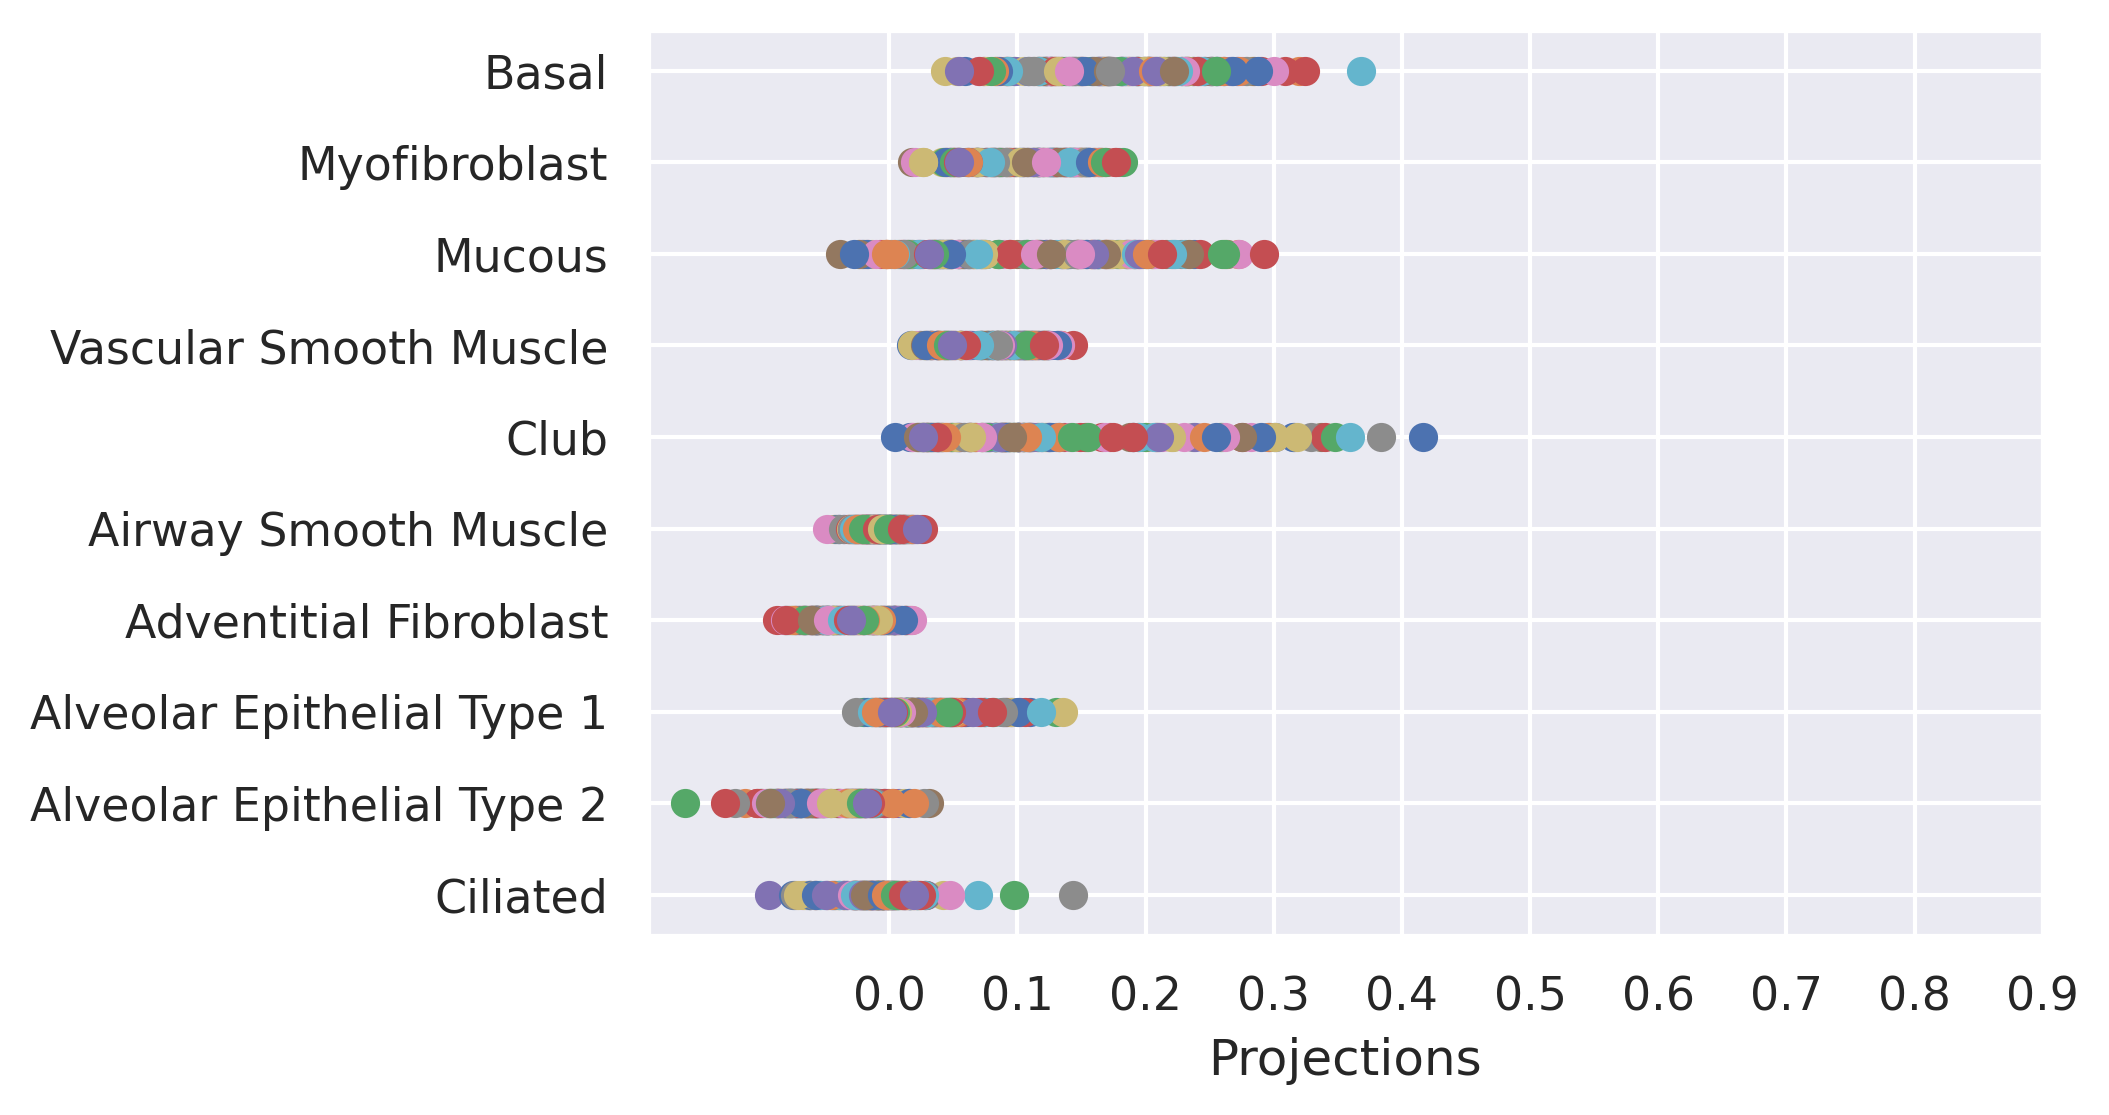

In [196]:
plt.figure()
ax = plt.gca()
n = 10
projections_sorted = scores.sort_values(by=scores.columns[0])
projections_top = projections_sorted.iloc[-n:]
ax.plot(projections_top.values, projections_top.index, 'o')
ax.set_xlabel('Projections')
# ax.grid()
ax.set_yticks(range(10))
ax.set_xticks(np.arange(10)/10.)

plt.show()

In [17]:
heatmap_list = []

for lung_type in lung_basis.columns:
    current_type_IDs = krasnow_metadata.index[krasnow_metadata.loc[:, 'free_annotation']==lung_type]
    current_type_IDs = np.intersect1d(current_type_IDs, test_IDs) # exclude training data
    current_projections = top.score(lung_basis, test_processed.loc[:, current_type_IDs])
    heatmap_list.append(current_projections.mean(axis=1))
    
heatmap_projections = pd.concat(heatmap_list, axis=1)
heatmap_projections.columns = lung_basis.columns

In [23]:
lung_types = {'Alveolar Epithelial Type 1': 'AT1',
                'Alveolar Epithelial Type 2': 'AT2',
                'Basal': 'Basal',
                'Club': 'Club',
                'Mucous': 'Mucous',
                'Ciliated':'Ciliated',
                'Airway Smooth Muscle': 'Airway muscle',
                'Vascular Smooth Muscle': 'Vascular muscle',
                'Pericyte': 'Pericyte',
                'Myofibroblast': 'Myofibroblast',
                'Adventitial Fibroblast': 'Adventitial fibroblast',
                'Alveolar Fibroblast': 'Alveolar fibroblast'
                }

relabeled_scores = heatmap_projections.loc[:, lung_types.keys()]
relabeled_scores = relabeled_scores.loc[lung_types.keys()]
relabeled_scores.columns = [lung_types[col] for col in relabeled_scores.columns]
relabeled_scores.index = [lung_types[row] for row in relabeled_scores.index]

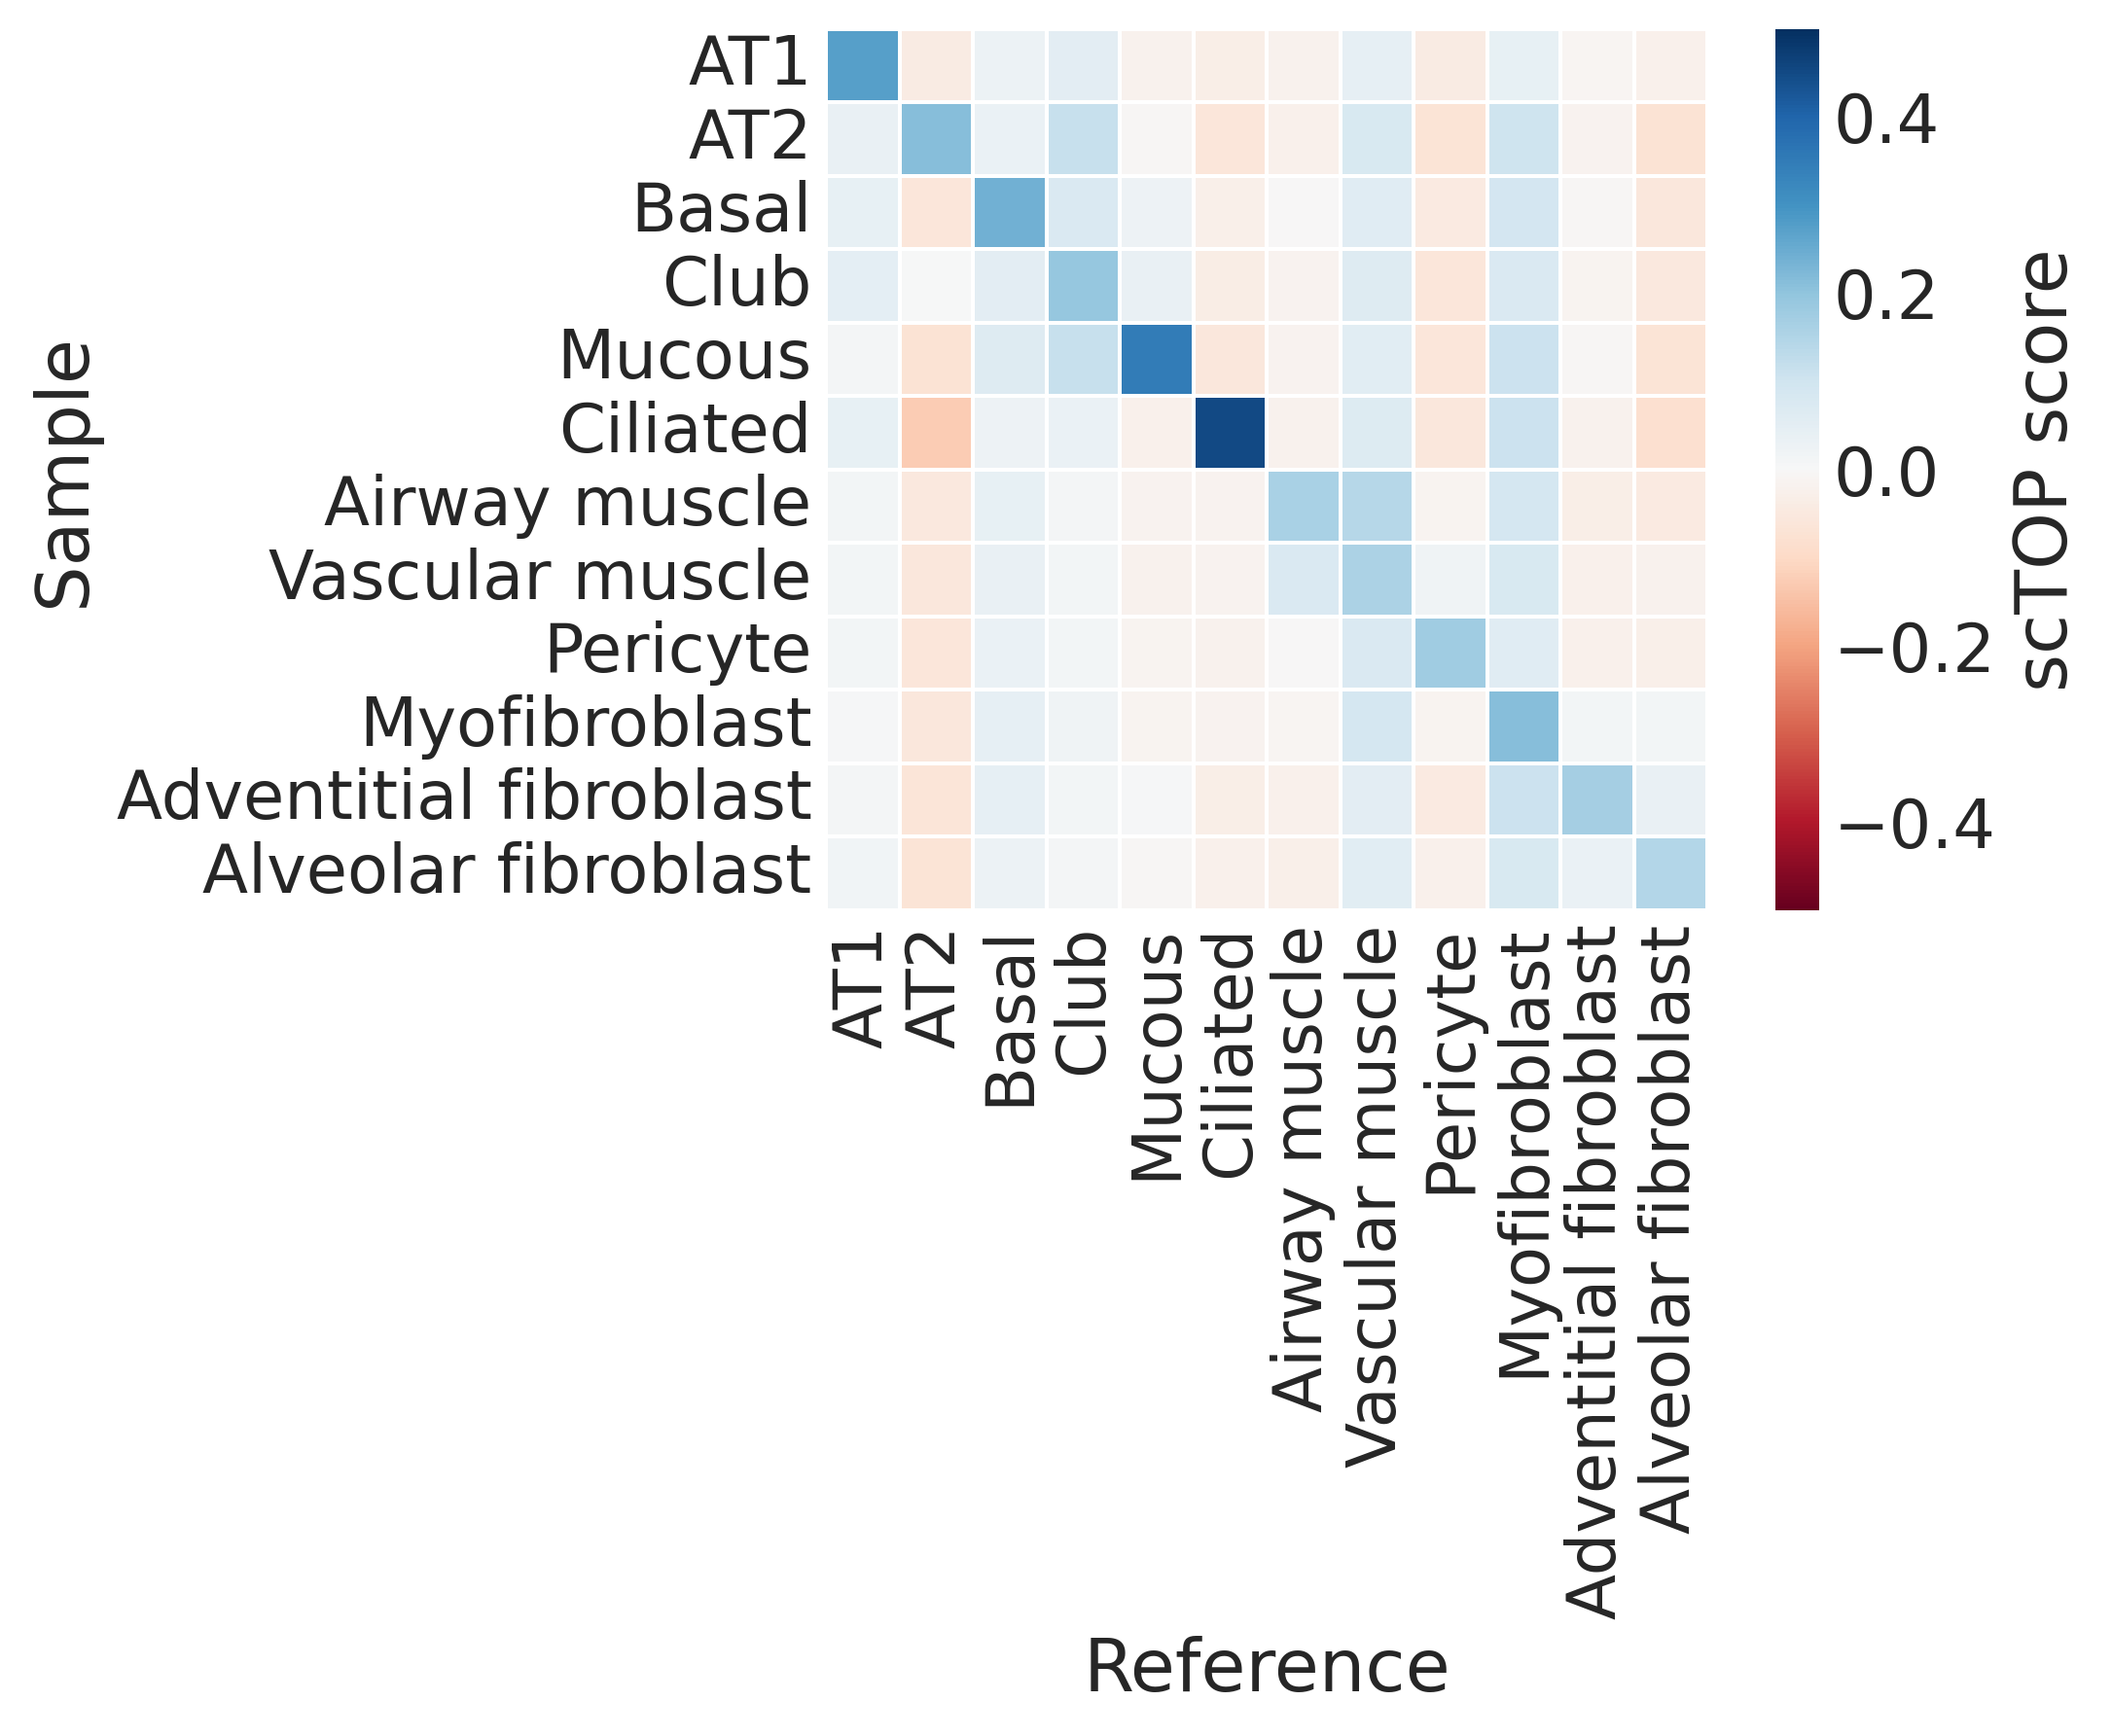

In [26]:
sns.heatmap(relabeled_scores.T, cmap="RdBu", 
            vmin=-0.5, vmax=0.5, 
            linewidths=.5, square=True, cbar_kws={'label':'scTOP score'})
plt.xlabel('Reference')
plt.ylabel('Sample')

plt.savefig("./manuscript figures/fig3b_lungatlas_heatmap.pdf", bbox_inches = "tight")